In [8]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# Step 1: Load dataset and filter classes with at least 170 images
dataset_path = "105_classes_pins_dataset"  # Update with the path to the dataset
output_path = "50classes_last2"  # Destination for the selected classes
min_images_per_class = 170  # Minimum number of images per class

# Create output directory if not exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [10]:

# Filter classes with at least the minimum number of images
all_classes = os.listdir(dataset_path)
selected_classes = []
for class_name in all_classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) >= min_images_per_class:
        selected_classes.append(class_name) #170 as min

# Limit to 50 classes (or any other number, if needed)
selected_classes = selected_classes[:50]  # Adjust the number of classes as needed

# Copy the filtered classes to the output directory
for class_name in selected_classes:
    class_path = os.path.join(dataset_path, class_name)
    dest_path = os.path.join(output_path, class_name)
    shutil.copytree(class_path, dest_path)


In [11]:
# Step 2: Split dataset into training and validation
train_path = os.path.join(output_path, "train")
val_path = os.path.join(output_path, "val")
if not os.path.exists(train_path) or not os.path.exists(val_path):
    os.makedirs(train_path)
    os.makedirs(val_path)

    for class_name in selected_classes:
        images = os.listdir(os.path.join(output_path, class_name))
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_name), exist_ok=True)
        
        for img in train_images:
            shutil.move(os.path.join(output_path, class_name, img),
                        os.path.join(train_path, class_name, img))
        for img in val_images:
            shutil.move(os.path.join(output_path, class_name, img),
                        os.path.join(val_path, class_name, img))


In [12]:
# Step 3: Data generators
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=image_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
    val_path, target_size=image_size, batch_size=batch_size, class_mode='categorical')


Found 7810 images belonging to 50 classes.
Found 1982 images belonging to 50 classes.


In [13]:
# Step 4: Define Xception Model with transfer learning
num_classes = len(selected_classes)
from tensorflow.keras.applications import Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Stop after 3 epochs with no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

In [18]:
# Step 5: Train the model with early stopping
epochs = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    verbose=1,
    callbacks=[early_stopping]  # Add early stopping
)

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1038s 4s/step - accuracy: 0.1063 - loss: 3.4044 - val_accuracy: 0.1967 - val_loss: 2.9100
Epoch 2/10
  1/244 ━━━━━━━━━━━━━━━━━━━━ 12:28 3s/step - accuracy: 0.3438 - loss: 2.6038

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


244/244 ━━━━━━━━━━━━━━━━━━━━ 184s 746ms/step - accuracy: 0.3438 - loss: 2.6038 - val_accuracy: 0.1890 - val_loss: 2.9119
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 942s 4s/step - accuracy: 0.2374 - loss: 2.7103 - val_accuracy: 0.2300 - val_loss: 2.7226
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 179s 725ms/step - accuracy: 0.2812 - loss: 2.4598 - val_accuracy: 0.2285 - val_loss: 2.7147
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 930s 4s/step - accuracy: 0.3162 - loss: 2.4361 - val_accuracy: 0.2382 - val_loss: 2.6797
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 182s 737ms/step - accuracy: 0.2812 - loss: 2.3006 - val_accuracy: 0.2408 - val_loss: 2.6886
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 919s 4s/step - accuracy: 0.3607 - loss: 2.2798 - val_accuracy: 0.2853 - val_loss: 2.5603
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 182s 733ms/step - accuracy: 0.3125 - loss: 2.4477 - val_accuracy: 0.2812 - val_loss: 2.5595
Epoch 9/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 935s 4s/step - accuracy: 0.3881 - loss: 2.1497 - val_acc

In [19]:
# Unfreeze some layers and fine-tune
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 5
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    verbose=1,
    callbacks=[early_stopping]  # Add early stopping to fine-tuning as well
)

# Step 6: Save the trained model
model.save("xceptionlast.keras")

Epoch 1/5
244/244 ━━━━━━━━━━━━━━━━━━━━ 1652s 7s/step - accuracy: 0.3614 - loss: 2.3149 - val_accuracy: 0.4657 - val_loss: 2.0150
Epoch 2/5
244/244 ━━━━━━━━━━━━━━━━━━━━ 233s 940ms/step - accuracy: 0.6875 - loss: 1.2713 - val_accuracy: 0.4677 - val_loss: 2.0116
Epoch 3/5
244/244 ━━━━━━━━━━━━━━━━━━━━ 1519s 6s/step - accuracy: 0.6418 - loss: 1.2455 - val_accuracy: 0.5676 - val_loss: 1.4926
Epoch 4/5
244/244 ━━━━━━━━━━━━━━━━━━━━ 185s 739ms/step - accuracy: 0.6875 - loss: 1.2211 - val_accuracy: 0.5717 - val_loss: 1.4851
Epoch 5/5
244/244 ━━━━━━━━━━━━━━━━━━━━ 1509s 6s/step - accuracy: 0.7518 - loss: 0.8624 - val_accuracy: 0.6347 - val_loss: 1.3365


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

62/62 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step


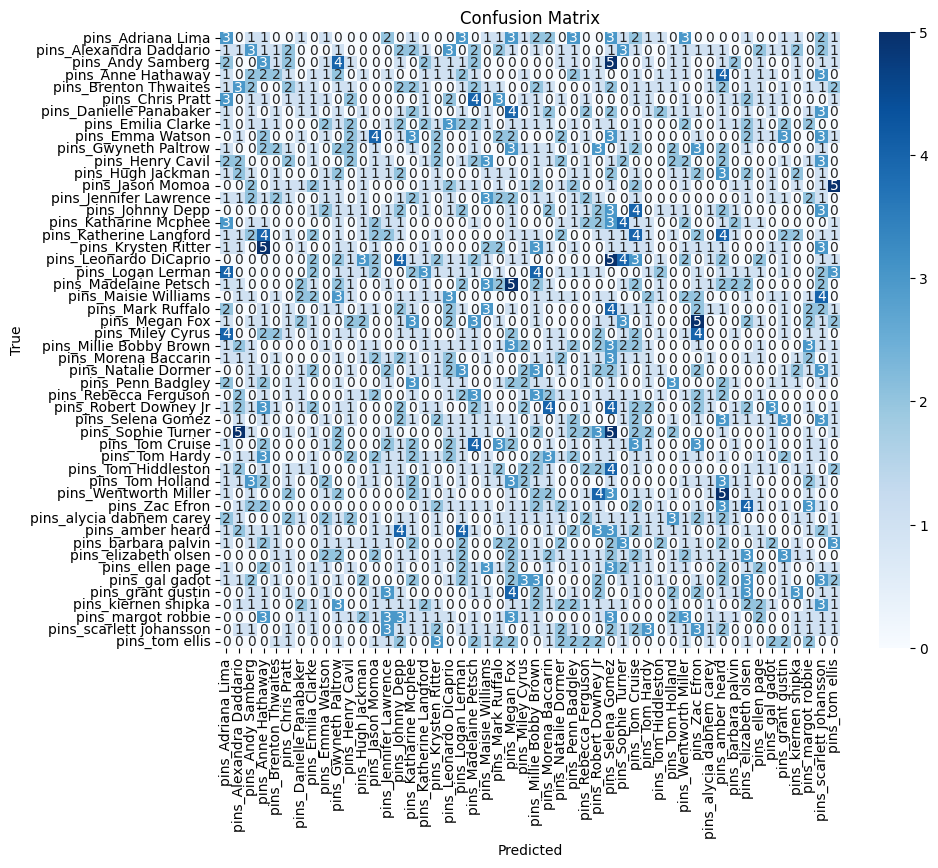

Classification Report:
                          precision    recall  f1-score   support

       pins_Adriana Lima       0.06      0.07      0.06        43
 pins_Alexandra Daddario       0.03      0.02      0.02        45
       pins_Andy Samberg       0.00      0.00      0.00        40
      pins_Anne Hathaway       0.04      0.05      0.04        41
   pins_Brenton Thwaites       0.00      0.00      0.00        42
        pins_Chris Pratt       0.03      0.03      0.03        36
 pins_Danielle Panabaker       0.05      0.03      0.03        37
      pins_Emilia Clarke       0.00      0.00      0.00        42
        pins_Emma Watson       0.04      0.02      0.03        43
    pins_Gwyneth Paltrow       0.04      0.05      0.05        38
        pins_Henry Cavil       0.06      0.05      0.06        39
       pins_Hugh Jackman       0.04      0.03      0.03        36
        pins_Jason Momoa       0.00      0.00      0.00        37
  pins_Jennifer Lawrence       0.00      0.00      0

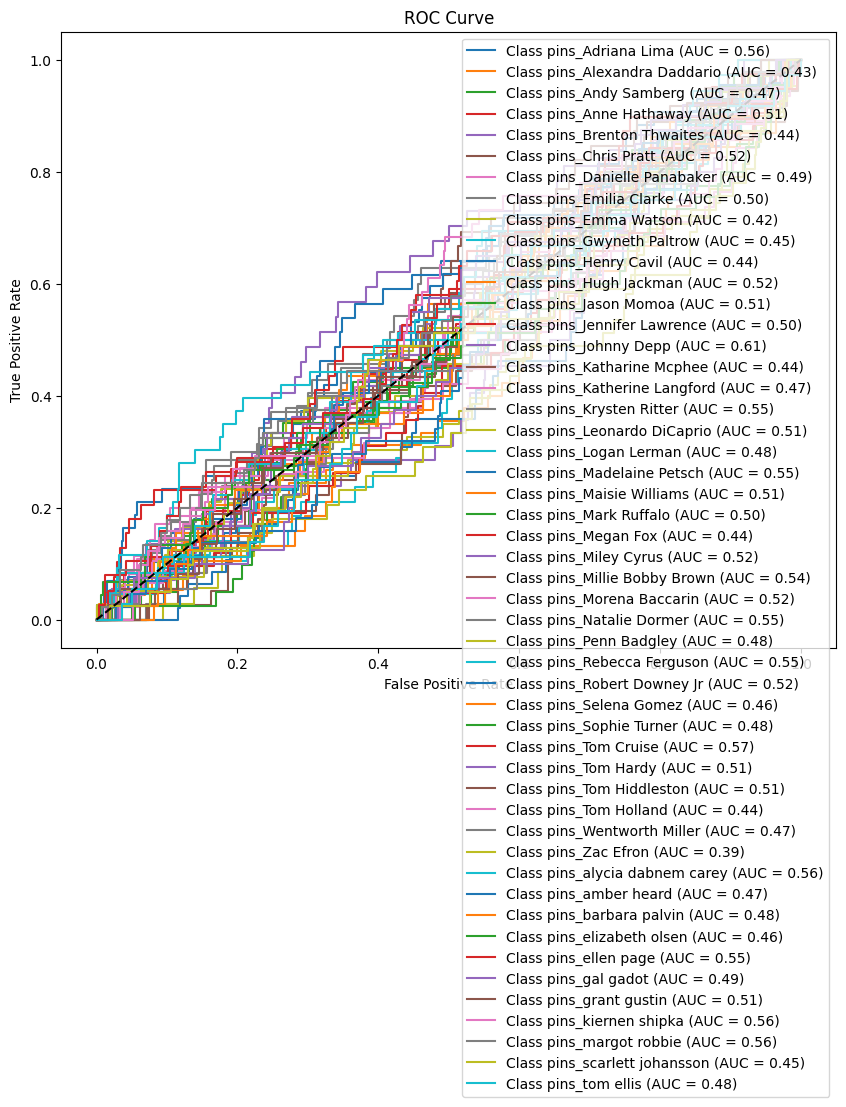

Overall AUC: 0.43


In [21]:
# Generate predictions for validation data
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class labels
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ROC Curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curves
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.show()

# Overall AUC
overall_auc = auc(fpr[1], tpr[1])  # Replace with the average AUC calculation if needed
print(f"Overall AUC: {overall_auc:.2f}")

# Test on a single image
def test_single_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image) / 255.0  # Normalize
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    prediction = model.predict(image_array)
    predicted_class = class_labels[np.argmax(prediction)]

    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

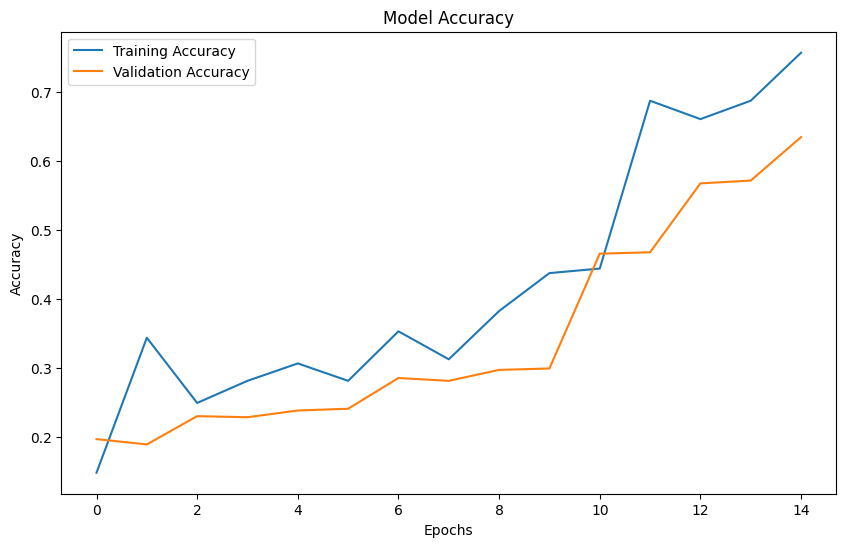

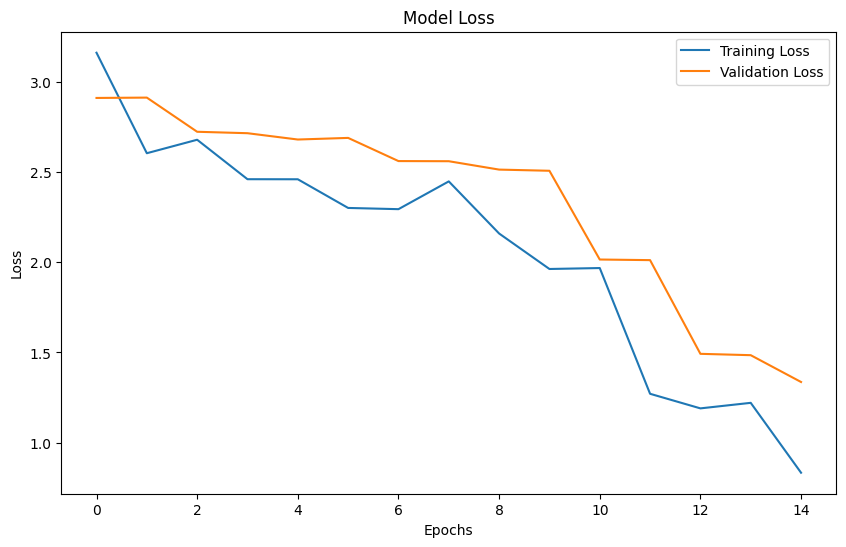

In [22]:
history_combined = {
    'accuracy': history.history['accuracy'] + history_fine_tune.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'],
    'loss': history.history['loss'] + history_fine_tune.history['loss'],
    'val_loss': history.history['val_loss'] + history_fine_tune.history['val_loss']
}

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_combined['accuracy'], label='Training Accuracy')
plt.plot(history_combined['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history_combined['loss'], label='Training Loss')
plt.plot(history_combined['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()